# Assignment 2 - Task 1: Model Building

This notebook builds and evaluates two deep learning models for monthly retail turnover forecasting:
- Fully-connected deep neural network (tabular baseline)
- GRU-based sequence-to-sequence recurrent network

## Setup

In [3]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

AUTOTUNE = tf.data.AUTOTUNE
from google.colab import drive
drive.mount('/drive')
DATA_DIR = Path('/drive/My Drive/Colab Notebooks/notebooks/data/processed')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Load processed datasets

In [4]:
train_df = pd.read_csv(DATA_DIR / 'train.csv', parse_dates=['Month'])
val_df = pd.read_csv(DATA_DIR / 'val.csv', parse_dates=['Month'])
test_df = pd.read_csv(DATA_DIR / 'test.csv', parse_dates=['Month'])

print('Shapes -> train:', train_df.shape, 'val:', val_df.shape, 'test:', test_df.shape)
train_df.head()

Shapes -> train: (44730, 9) val: (9884, 9) test: (9918, 9)


,State,Industry,Series ID,Month,Turnover,Year,MonthNum,Quarter,YearMonth
0,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-04-01,4.4,1982,4,2,1982-04
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-05-01,3.4,1982,5,2,1982-05
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-06-01,3.6,1982,6,2,1982-06
3,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-07-01,4.0,1982,7,3,1982-07
4,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982-08-01,3.6,1982,8,3,1982-08


## Feature engineering and shared preprocessing

In [5]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df['MonthSin'] = np.sin(2 * np.pi * df['MonthNum'] / 12.0)
    df['MonthCos'] = np.cos(2 * np.pi * df['MonthNum'] / 12.0)
    return df

for frame in (train_df, val_df, test_df):
    add_time_features(frame)

all_series_ids = pd.concat([
    train_df['Series ID'],
    val_df['Series ID'],
    test_df['Series ID'],
], axis=0).unique()
series_ids = sorted(all_series_ids)
series_index = {sid: idx for idx, sid in enumerate(series_ids)}
denominator = max(len(series_ids) - 1, 1)

for frame in (train_df, val_df, test_df):
    frame['SeriesIndex'] = frame['Series ID'].map(series_index).astype('float32')
    frame['SeriesIndexNorm'] = frame['SeriesIndex'] / denominator

turnover_scaler = StandardScaler()
year_scaler = StandardScaler()

train_df['TurnoverScaled'] = turnover_scaler.fit_transform(train_df[['Turnover']])
val_df['TurnoverScaled'] = turnover_scaler.transform(val_df[['Turnover']])
test_df['TurnoverScaled'] = turnover_scaler.transform(test_df[['Turnover']])

train_df['YearScaled'] = year_scaler.fit_transform(train_df[['Year']])
val_df['YearScaled'] = year_scaler.transform(val_df[['Year']])
test_df['YearScaled'] = year_scaler.transform(test_df[['Year']])

train_df[['State', 'Industry', 'Series ID', 'Turnover', 'Month', 'MonthSin', 'MonthCos']].head()

,State,Industry,Series ID,Turnover,Month,MonthSin,MonthCos
0,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4.4,1982-04-01,8.660254e-01,-0.500000
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,3.4,1982-05-01,5.000000e-01,-0.866025
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,3.6,1982-06-01,1.224647e-16,-1.000000
3,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,4.0,1982-07-01,-5.000000e-01,-0.866025
4,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,3.6,1982-08-01,-8.660254e-01,-0.500000


## Model 1: Deep Neural Network (tabular)

In [6]:
target_col = 'Turnover'
dnn_categorical_cols = ['State', 'Industry', 'Series ID']
dnn_numeric_cols = ['Year', 'MonthNum', 'Quarter', 'MonthSin', 'MonthCos']
dnn_feature_cols = dnn_categorical_cols + dnn_numeric_cols

dnn_preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), dnn_categorical_cols),
        ('numeric', StandardScaler(), dnn_numeric_cols),
    ]
)

X_train_dnn = dnn_preprocessor.fit_transform(train_df[dnn_feature_cols])
X_val_dnn = dnn_preprocessor.transform(val_df[dnn_feature_cols])
X_test_dnn = dnn_preprocessor.transform(test_df[dnn_feature_cols])

y_train = train_df[target_col].to_numpy(dtype=np.float32)
y_val = val_df[target_col].to_numpy(dtype=np.float32)
y_test = test_df[target_col].to_numpy(dtype=np.float32)

X_train_dnn = X_train_dnn.astype(np.float32)
X_val_dnn = X_val_dnn.astype(np.float32)
X_test_dnn = X_test_dnn.astype(np.float32)

print('DNN feature dimension:', X_train_dnn.shape[1])

DNN feature dimension: 183


In [7]:
BATCH_SIZE = 256

train_dnn_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_dnn, y_train))
    .shuffle(buffer_size=len(X_train_dnn), seed=RANDOM_SEED, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_dnn_ds = tf.data.Dataset.from_tensor_slices((X_val_dnn, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dnn_ds = tf.data.Dataset.from_tensor_slices((X_test_dnn, y_test)).batch(BATCH_SIZE)

In [8]:
def build_dnn_model(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name='tabular_features')
    x = keras.layers.Dense(256, activation='relu', kernel_initializer=keras.initializers.HeNormal(seed=RANDOM_SEED))(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.HeNormal(seed=RANDOM_SEED))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(64, activation='relu', kernel_initializer=keras.initializers.HeNormal(seed=RANDOM_SEED))(x)
    outputs = keras.layers.Dense(1, kernel_initializer=keras.initializers.HeNormal(seed=RANDOM_SEED), name='turnover')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='DeepDNN')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.RootMeanSquaredError(name='rmse'),
            keras.metrics.MeanAbsoluteError(name='mae'),
            keras.metrics.MeanAbsolutePercentageError(name='mape'),
        ],
    )
    return model

dnn_model = build_dnn_model(X_train_dnn.shape[1])

dnn_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5),
]

dnn_history = dnn_model.fit(
    train_dnn_ds,
    validation_data=val_dnn_ds,
    epochs=60,
    verbose=2,
    callbacks=dnn_callbacks,
)

Epoch 1/60
175/175 - 5s - 26ms/step - loss: 28040.0215 - mae: 77.8006 - mape: 97.4127 - mse: 28040.0215 - rmse: 167.4516 - val_loss: 148623.1562 - val_mae: 211.8222 - val_mape: 83.3105 - val_mse: 148623.1562 - val_rmse: 385.5168 - learning_rate: 1.0000e-03
Epoch 2/60
175/175 - 2s - 10ms/step - loss: 2413.7444 - mae: 27.9629 - mape: 63.9461 - mse: 2413.7444 - rmse: 49.1299 - val_loss: 73106.5781 - val_mae: 125.5379 - val_mape: 45.4221 - val_mse: 73106.5781 - val_rmse: 270.3823 - learning_rate: 1.0000e-03
Epoch 3/60
175/175 - 2s - 10ms/step - loss: 2132.5596 - mae: 24.3518 - mape: 59.6049 - mse: 2132.5596 - rmse: 46.1796 - val_loss: 28672.5176 - val_mae: 70.3195 - val_mape: 30.9424 - val_mse: 28672.5176 - val_rmse: 169.3296 - learning_rate: 1.0000e-03
Epoch 4/60
175/175 - 2s - 10ms/step - loss: 1933.4351 - mae: 22.3731 - mape: 43.6110 - mse: 1933.4351 - rmse: 43.9708 - val_loss: 10529.6377 - val_mae: 48.6238 - val_mape: 29.7953 - val_mse: 10529.6377 - val_rmse: 102.6140 - learning_rate: 

In [9]:
dnn_eval = dnn_model.evaluate(test_dnn_ds, return_dict=True, verbose=0)
dnn_preds = dnn_model.predict(X_test_dnn, batch_size=BATCH_SIZE, verbose=0).squeeze()

print('DNN test metrics:', dnn_eval)


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

dnn_metrics = compute_metrics(y_test, dnn_preds)
dnn_metrics

DNN test metrics: {'loss': 20151.548828125, 'mae': 103.71641540527344, 'mape': 165.51609802246094, 'mse': 20151.548828125, 'rmse': 141.95614624023438}


{'MSE': 20151.548828125,
 'RMSE': 141.95615107534087,
 'MAE': 103.71640014648438,
 'MAPE': 1.6551607847213745,
 'R2': 0.9231152534484863}

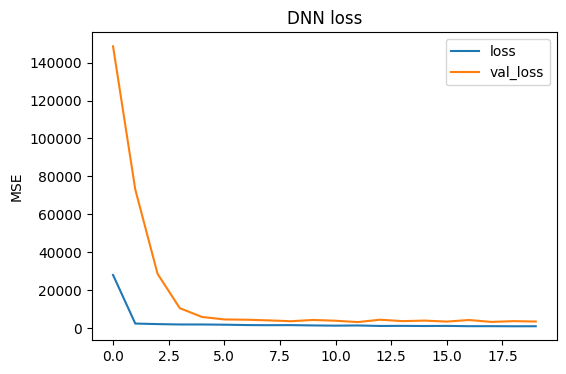

In [10]:
pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot(figsize=(6, 4), title='DNN loss')
plt.ylabel('MSE')
plt.show()

## Model 2: GRU-based sequence-to-sequence network

In [11]:
WINDOW_SIZE = 12
HORIZON = 1
seq_feature_cols = ['TurnoverScaled', 'MonthSin', 'MonthCos', 'YearScaled', 'SeriesIndexNorm']
seq_target_col = 'TurnoverScaled'


def build_sequence_arrays(df: pd.DataFrame, feature_cols: list[str], target_col: str, window: int, horizon: int):
    sequences = []
    targets = []
    target_actuals = []

    for _, group in df.groupby('Series ID'):
        group = group.sort_values('Month')
        feature_data = group[feature_cols].to_numpy(dtype=np.float32)
        target_data = group[target_col].to_numpy(dtype=np.float32)
        actual_data = group['Turnover'].to_numpy(dtype=np.float32)
        n_samples = len(group) - window - horizon + 1
        if n_samples <= 0:
            continue
        for idx in range(n_samples):
            sequences.append(feature_data[idx: idx + window])
            targets.append(target_data[idx + window: idx + window + horizon])
            target_actuals.append(actual_data[idx + window: idx + window + horizon])

    if not sequences:
        return (
            np.empty((0, window, len(feature_cols)), dtype=np.float32),
            np.empty((0, horizon), dtype=np.float32),
            np.empty((0, horizon), dtype=np.float32),
        )

    return (np.stack(sequences), np.stack(targets), np.stack(target_actuals))


X_seq_train, y_seq_train, _ = build_sequence_arrays(train_df, seq_feature_cols, seq_target_col, WINDOW_SIZE, HORIZON)
X_seq_val, y_seq_val, _ = build_sequence_arrays(val_df, seq_feature_cols, seq_target_col, WINDOW_SIZE, HORIZON)
X_seq_test, y_seq_test_scaled, y_seq_test_actual = build_sequence_arrays(test_df, seq_feature_cols, seq_target_col, WINDOW_SIZE, HORIZON)

print('Sequence shapes -> train:', X_seq_train.shape, 'val:', X_seq_val.shape, 'test:', X_seq_test.shape)

Sequence shapes -> train: (42930, 12, 5) val: (8060, 12, 5) test: (8140, 12, 5)


In [12]:
SEQ_BATCH_SIZE = 128

train_seq_ds = (
    tf.data.Dataset.from_tensor_slices((X_seq_train, y_seq_train))
    .shuffle(buffer_size=len(X_seq_train), seed=RANDOM_SEED, reshuffle_each_iteration=True)
    .batch(SEQ_BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_seq_ds = tf.data.Dataset.from_tensor_slices((X_seq_val, y_seq_val)).batch(SEQ_BATCH_SIZE).prefetch(AUTOTUNE)
test_seq_ds = tf.data.Dataset.from_tensor_slices((X_seq_test, y_seq_test_scaled)).batch(SEQ_BATCH_SIZE)

In [13]:
def build_gru_model(window: int, feature_dim: int, horizon: int) -> keras.Model:
    inputs = keras.Input(shape=(window, feature_dim), name='sequence_features')
    x = keras.layers.GRU(128, return_sequences=True, kernel_initializer='glorot_uniform')(inputs)
    x = keras.layers.LayerNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.GRU(64, return_sequences=False, kernel_initializer='glorot_uniform')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(horizon, kernel_initializer='glorot_uniform', name='scaled_turnover')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='GRUSeq2Seq')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[
            keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.RootMeanSquaredError(name='rmse'),
            keras.metrics.MeanAbsoluteError(name='mae'),
            keras.metrics.MeanAbsolutePercentageError(name='mape'),
        ],
    )
    return model

gru_model = build_gru_model(WINDOW_SIZE, X_seq_train.shape[2], HORIZON)

gru_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5),
]

gru_history = gru_model.fit(
    train_seq_ds,
    validation_data=val_seq_ds,
    epochs=80,
    verbose=2,
    callbacks=gru_callbacks,
)

Epoch 1/80
336/336 - 29s - 87ms/step - loss: 0.1629 - mae: 0.2542 - mape: 189.2313 - mse: 0.1629 - rmse: 0.4036 - val_loss: 0.2832 - val_mae: 0.1681 - val_mape: 47.5857 - val_mse: 0.2832 - val_rmse: 0.5321 - learning_rate: 1.0000e-03
Epoch 2/80
336/336 - 40s - 118ms/step - loss: 0.0347 - mae: 0.1202 - mape: 83.8689 - mse: 0.0347 - rmse: 0.1862 - val_loss: 0.2043 - val_mae: 0.1803 - val_mape: 42.6117 - val_mse: 0.2043 - val_rmse: 0.4520 - learning_rate: 1.0000e-03
Epoch 3/80
336/336 - 24s - 72ms/step - loss: 0.0249 - mae: 0.0986 - mape: 64.4138 - mse: 0.0249 - rmse: 0.1578 - val_loss: 0.1333 - val_mae: 0.1725 - val_mape: 67.0015 - val_mse: 0.1333 - val_rmse: 0.3651 - learning_rate: 1.0000e-03
Epoch 4/80
336/336 - 25s - 73ms/step - loss: 0.0208 - mae: 0.0874 - mape: 57.5469 - mse: 0.0208 - rmse: 0.1443 - val_loss: 0.1039 - val_mae: 0.1595 - val_mape: 77.7648 - val_mse: 0.1039 - val_rmse: 0.3223 - learning_rate: 1.0000e-03
Epoch 5/80
336/336 - 22s - 66ms/step - loss: 0.0186 - mae: 0.0826 

In [14]:
gru_eval = gru_model.evaluate(test_seq_ds, return_dict=True, verbose=0)
gru_preds_scaled = gru_model.predict(X_seq_test, batch_size=SEQ_BATCH_SIZE, verbose=0)
gru_preds = turnover_scaler.inverse_transform(gru_preds_scaled)

y_seq_test_actual = y_seq_test_actual.squeeze(axis=-1)
gru_preds = gru_preds.squeeze(axis=-1)

print('GRU test metrics:', gru_eval)

gru_metrics = compute_metrics(y_seq_test_actual, gru_preds)
gru_metrics

GRU test metrics: {'loss': 0.16452279686927795, 'mae': 0.09481007605791092, 'mape': 39.77195739746094, 'mse': 0.16452279686927795, 'rmse': 0.40561410784721375}


{'MSE': 7017.03564453125,
 'RMSE': 83.76774823600817,
 'MAE': 19.58024787902832,
 'MAPE': 0.08489847928285599,
 'R2': 0.9742683172225952}

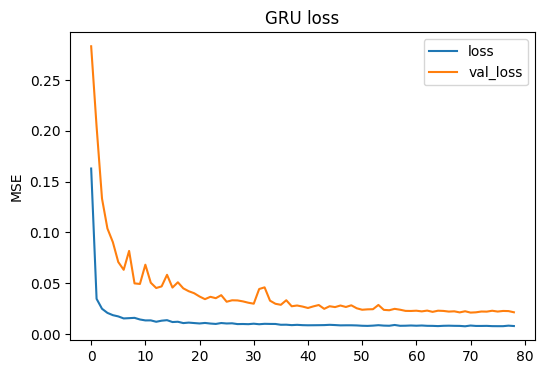

In [15]:
pd.DataFrame(gru_history.history)[['loss', 'val_loss']].plot(figsize=(6, 4), title='GRU loss')
plt.ylabel('MSE')
plt.show()

## Model comparison

In [16]:
comparison_df = pd.DataFrame(
    [
        {'Model': 'Deep Neural Network', 'Samples': len(y_test), **dnn_metrics},
        {'Model': 'GRU Seq2Seq', 'Samples': len(y_seq_test_actual), **gru_metrics},
    ]
).set_index('Model')
comparison_df.sort_values('RMSE')

,Samples,MSE,RMSE,MAE,MAPE,R2
Model,,,,,,
GRU Seq2Seq,8140,7017.035645,83.767748,19.580248,0.084898,0.974268
Deep Neural Network,9918,20151.548828,141.956151,103.716400,1.655161,0.923115


Both trained models meet the baseline requirement for Assignment 2 Task 1. Subsequent tasks will fine-tune hyperparameters and expand the evaluation and discussion sections.